# Introduction
---
In this project we'll be working on developing a machine learning model for <em>Rusty Bargain Car Sales</em>. We will develop a few different models to compare the following:
- quality of predictions
- speed of predictions
- time required for training

We will score our models according to RMSE. Gradient Boosting will be the area of focus here. In this project we'll utilize these three gradient boosting frameworks:
- XGBoost
- CatBoost
- LightGBM

We'll explore the differences along with their strength and weaknesses. After running each test we'll choose which model best fit our requirements.

The dataset we'll be using can be found at <a href='https://practicum-content.s3.us-west-1.amazonaws.com/datasets/car_data.csv'>https://practicum-content.s3.us-west-1.amazonaws.com/datasets/car_data.csv</a>.

Project stages:
1. Data Preparation
2. Model Creation/Testing
3. Model Analyses
4. Conclusion

## Data Preparation
---

In [92]:
# Importing dependencies
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor, Pool
import xgboost as xgb
import lightgbm  as lgb
from flaml.default import LGBMRegressor

In [93]:
sns.set_theme("notebook","darkgrid")

In [94]:
# Loading dataset with preview
df = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/car_data.csv')
df.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [96]:
df.shape

(354369, 16)

After a quick bird's eye view on the data the following will have to be done:
- drop any duplicates
- columns have to be renames to standard form
- drop `DateCrawled`, `PostalCode`, `RegistraitonYear`, `RegistrationMonth`, `NumberOfPictures`, `LastSeen`, & `DateCreated`
- Create a `dom` column showing the length of time the vehicle has been listed for sale
- missing values have to be addressed

In [97]:
df[df['DateCrawled'] == '31/03/2016 23:58']
# print(df['RegistrationYear'].max())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
59100,31/03/2016 23:58,8500,coupe,1988,auto,132,other,50000,4,petrol,mercedes_benz,no,31/03/2016 00:00,0,70437,01/04/2016 07:44
78345,31/03/2016 23:58,0,NaN,2018,NaN,0,c2,150000,0,NaN,citroen,NaN,31/03/2016 00:00,0,49610,07/04/2016 04:16
102507,31/03/2016 23:58,120,small,1999,manual,54,other,150000,0,petrol,skoda,NaN,31/03/2016 00:00,0,84529,07/04/2016 04:16
123376,31/03/2016 23:58,4800,bus,2003,manual,101,touran,125000,12,gasoline,volkswagen,yes,31/03/2016 00:00,0,72172,01/04/2016 07:44
201546,31/03/2016 23:58,3399,bus,2001,manual,0,alhambra,150000,11,gasoline,seat,yes,31/03/2016 00:00,0,97424,07/04/2016 04:16
345137,31/03/2016 23:58,1199,small,2001,manual,75,lupo,150000,11,petrol,volkswagen,yes,31/03/2016 00:00,0,91177,07/04/2016 04:16


In [98]:
# Removing duplicates
df = df.drop_duplicates()
df.duplicated().sum()

0

In [99]:
df = df.drop(['DateCrawled','PostalCode','RegistrationYear','RegistrationMonth','NumberOfPictures'], axis=1)

In [100]:
# Changing columns names
df = df.rename(columns={
    'Price':'price',
    'VehicleType':'vehicle_type',
    'Gearbox':'gearbox',
    'Power':'power',
    'Model':'model',
    'Mileage':'mileage',
    'FuelType':'fuel_type',
    'Brand':'make',
    'NotRepaired':'not_repaired',
    'DateCreated':'date_created',
    'LastSeen':'last_seen'
})

In [101]:
# Joining `make` and `model` columns
df['make_model'] = df['make'].str.cat(df['model'],sep="_")
df = df.drop(['make','model'],axis=1)
df.columns

Index(['price', 'vehicle_type', 'gearbox', 'power', 'mileage', 'fuel_type',
       'not_repaired', 'date_created', 'last_seen', 'make_model'],
      dtype='object')

In [102]:
# Iterating datetime tyme conversion
date_cols = ['date_created','last_seen']
for col in date_cols:
    df[col] = pd.to_datetime(df[col],dayfirst=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354107 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   price         354107 non-null  int64         
 1   vehicle_type  316623 non-null  object        
 2   gearbox       334277 non-null  object        
 3   power         354107 non-null  int64         
 4   mileage       354107 non-null  int64         
 5   fuel_type     321218 non-null  object        
 6   not_repaired  282962 non-null  object        
 7   date_created  354107 non-null  datetime64[ns]
 8   last_seen     354107 non-null  datetime64[ns]
 9   make_model    334406 non-null  object        
dtypes: datetime64[ns](2), int64(3), object(5)
memory usage: 29.7+ MB


In [103]:
# Checking for date range
df['last_seen'].describe()

count                           354107
mean     2016-03-29 23:51:12.374903808
min                2016-03-05 14:15:00
25%                2016-03-23 02:50:00
50%                2016-04-03 15:15:00
75%                2016-04-06 10:06:00
max                2016-04-07 14:58:00
Name: last_seen, dtype: object

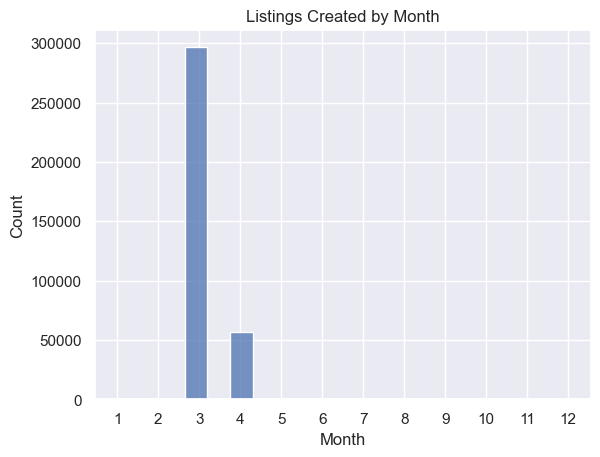

In [104]:
# Plotting number of new car listings per month
sns.histplot(df['date_created'].dt.month)

plt.title('Listings Created by Month')
plt.xlabel('Month')
plt.xticks(np.arange(1,13,1))

plt.show()

The month there were the most listings created has been March and April. We've got a decent measure of supply but we're missing data that tracks demand. A field that track views for each observation would give valuable insights on the market and service.

In [105]:
df['date_created'].describe()

count                           354107
mean     2016-03-20 19:11:13.738728960
min                2014-03-10 00:00:00
25%                2016-03-13 00:00:00
50%                2016-03-21 00:00:00
75%                2016-03-29 00:00:00
max                2016-04-07 00:00:00
Name: date_created, dtype: object

The oldest data here is from year 2014. The current date on this dataset is 04-07-2016. We will need to keep the most recent 3 month data in order to capture recent trends.

In [106]:
# Filtereing out data older than 3 months
df = df[(df['date_created'].dt.month >= 1)&(df['date_created'].dt.year == 2016)&(df['date_created'].dt.day >= 7)]
df['date_created'].describe()

count                           282770
mean     2016-03-19 00:51:03.736606208
min                2016-01-07 00:00:00
25%                2016-03-12 00:00:00
50%                2016-03-19 00:00:00
75%                2016-03-25 00:00:00
max                2016-04-07 00:00:00
Name: date_created, dtype: object

Now that we've extracted the relevant data, we can now create new features for each datetime column that will have month and day respectively for each feature for our models to process. We'll then drop the datetime columns and keep the month and day features. 

We'll feature engineer a new column that'll show days on market `dom`. This will reflect how long these listing. have been for sale.

In [107]:
# Creating `DOM` column
df['dom'] = df['last_seen'] - df['date_created']
df = df.drop(['last_seen','date_created'],axis=1)
df.head(3)

,price,vehicle_type,gearbox,power,mileage,fuel_type,not_repaired,make_model,dom
0,480,NaN,manual,0,150000,petrol,NaN,volkswagen_golf,14 days 03:16:00
1,18300,coupe,manual,190,125000,gasoline,yes,NaN,14 days 01:46:00
2,9800,suv,auto,163,125000,gasoline,NaN,jeep_grand,22 days 12:47:00


In [108]:
df.isna().sum()/df.shape[0]

price           0.000000
vehicle_type    0.106868
gearbox         0.056862
power           0.000000
mileage         0.000000
fuel_type       0.093861
not_repaired    0.202164
make_model      0.055936
dom             0.000000
dtype: float64

We have about 5.5% of the data with missing make_model values. These observations will not help us with our model training. We'll remove these obervations.

In [109]:
# Dropping observations with missing make/model values
df = df.dropna(subset=['make_model'],axis=0)
df['make_model'].isna().sum()

0

In [110]:
# Checking mileage column
df['mileage'].describe()

count    266953.000000
mean     128628.204216
std       37194.960235
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: mileage, dtype: float64

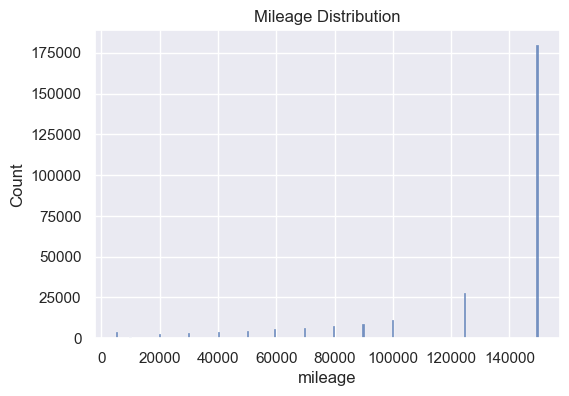

In [111]:
plt.figure(figsize=(6,4))
sns.histplot(df['mileage'])
plt.title('Mileage Distribution')
plt.show()

In [112]:
# Checking `price` column description
df['price'].describe()

count    266953.000000
mean       4466.999389
std        4513.228166
min           0.000000
25%        1100.000000
50%        2800.000000
75%        6499.000000
max       20000.000000
Name: price, dtype: float64

Number of outliers:  13469


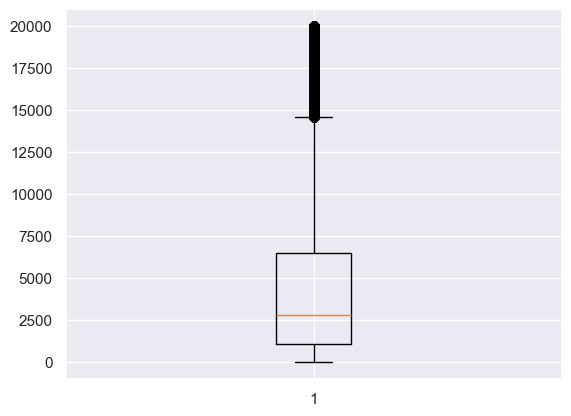

In [113]:
boxplot = plt.boxplot(df['price'].values)
outliers = list(boxplot['fliers'][0].get_data()[1])
df_outliers = df[df['price'].isin(outliers)]
print('Number of outliers: ',len(outliers))

In [114]:
df['power'].describe()

count    266953.000000
mean        111.140002
std         187.548125
min           0.000000
25%          70.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

In [115]:
df['dom'] = df['dom'].dt.days
df['dom'].describe()

count    266953.000000
mean          9.648418
std           8.366492
min           0.000000
25%           2.000000
50%           8.000000
75%          15.000000
max          91.000000
Name: dom, dtype: float64

Outliers detected in `mileage`, `power`, `dom` and `price` columns. We'll remove any observations 3 standard deviations above & below the mean.

In [116]:
outliers = ['price','mileage','power','dom']
# Filtering out the outliers
df = df[(np.abs(st.zscore(df[outliers]) < 3).all(axis=1))]
df.head()

,price,vehicle_type,gearbox,power,mileage,fuel_type,not_repaired,make_model,dom
0,480,NaN,manual,0,150000,petrol,NaN,volkswagen_golf,14
2,9800,suv,auto,163,125000,gasoline,NaN,jeep_grand,22
3,1500,small,manual,75,150000,petrol,no,volkswagen_golf,0
4,3600,small,manual,69,90000,gasoline,no,skoda_fabia,6
7,0,sedan,manual,50,40000,petrol,no,volkswagen_other,4


In [117]:
df.describe()

,price,power,mileage,dom
count,262848.000000,262848.000000,262848.000000,262848.000000
mean,4263.262559,106.656357,129229.802015,9.566407
std,4196.304756,61.687015,36689.562405,8.269516
min,0.000000,0.000000,5000.000000,0.000000
25%,1100.000000,69.000000,125000.000000,2.000000
50%,2700.000000,105.000000,150000.000000,8.000000
75%,6200.000000,140.000000,150000.000000,15.000000
max,18000.000000,671.000000,150000.000000,34.000000


<Axes: xlabel='dom'>

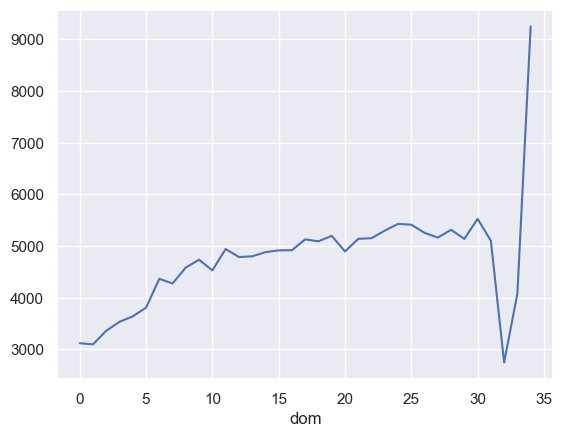

In [118]:
df.groupby('dom')['price'].mean().plot()

Here we see as the longer the listing is on the market indicates a higher price. The lower the price, the more buyers on the market. Higher price thins out the available buyers on the market at those given prices. Could also be possible the vehicle is overpriced.

In [119]:
# Checking vehicle type values
df['vehicle_type'].value_counts(dropna=False)

vehicle_type
sedan          69289
small          60855
wagon          49533
NaN            24563
bus            21803
convertible    14310
coupe          11693
suv             8542
other           2260
Name: count, dtype: int64

We have about 24 thousand missing `vehicle_type` values. We'll just rename these values as 'unknown' 

In [120]:
# Replacing missing values with 'unknown' value
df['vehicle_type'] = df['vehicle_type'].fillna('unknown')
df['vehicle_type'].value_counts()

vehicle_type
sedan          69289
small          60855
wagon          49533
unknown        24563
bus            21803
convertible    14310
coupe          11693
suv             8542
other           2260
Name: count, dtype: int64

In [121]:
# Checking `gearbox` values
df['gearbox'].value_counts(dropna=False)

gearbox
manual    201791
auto       48380
NaN        12677
Name: count, dtype: int64

We have no way to determine the true values of these missing values. We can still use this data so we can just fill these in with 'unknown' values.

In [122]:
# Filling missing `gearbox` values with 'unknown'
df['gearbox'] = df['gearbox'].fillna('unknown')
df['gearbox'].value_counts()

gearbox
manual     201791
auto        48380
unknown     12677
Name: count, dtype: int64

In [123]:
# Checking `fuel_type` values
df['fuel_type'].value_counts(dropna=False)

fuel_type
petrol      162962
gasoline     74546
NaN          20605
lpg           3970
cng            449
hybrid         155
other          108
electric        53
Name: count, dtype: int64

We've no clue on how to determine the true values of the missing instances. We'll again fill these with 'unknown' string values. We will also combine pretrol and gasoline fuel types. We'll also combine the three lowest count values as 'other'. We're going to take those 'other's and remove them.

In [124]:
df['fuel_type'] = df['fuel_type'].fillna('unknown')
df['fuel_type'] = df['fuel_type'].replace({
    'hybrid' : 'other', 
    'electric' : 'other', 
    'petrol' : 'gasoline',
    'cng':'other'
    })
df = df[df['fuel_type'] != 'other']
df['fuel_type'].value_counts()

fuel_type
gasoline    237508
unknown      20605
lpg           3970
Name: count, dtype: int64

In [125]:
# Checking `not_repaired` values
df['not_repaired'].value_counts(dropna=False)

not_repaired
no     185706
NaN     49466
yes     26911
Name: count, dtype: int64

In [126]:
# Filling missing values with 'unknown' string values
df['not_repaired'] = df['not_repaired'].fillna('unknown')
df['not_repaired'].value_counts()

not_repaired
no         185706
unknown     49466
yes         26911
Name: count, dtype: int64

In [127]:
df.isna().sum()/df.shape[0]

price           0.0
vehicle_type    0.0
gearbox         0.0
power           0.0
mileage         0.0
fuel_type       0.0
not_repaired    0.0
make_model      0.0
dom             0.0
dtype: float64

No reason to keep this coulumn as there are only zeros. The model will not have any data to learn from this feature so will only contribute to longer, unnecessary, training time.

Let's check for any duplicates after consolidating same categorical types with different names.

In [128]:
# Final chekc for dupliacates
print('Number of duplicates: ', df.duplicated().sum())
df = df.drop_duplicates()
df.duplicated().sum()

Number of duplicates:  14071


0

In [129]:
df.shape

(248012, 9)

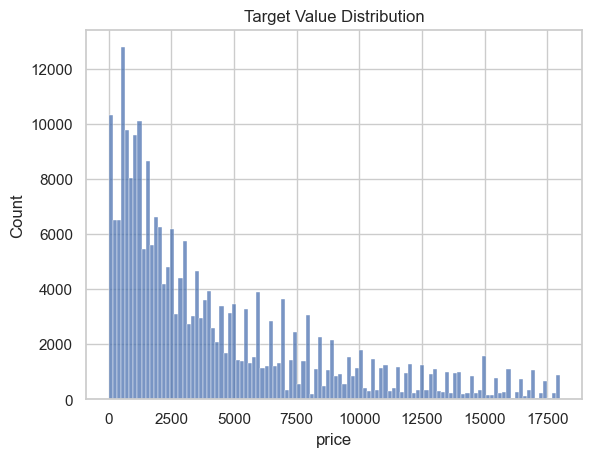

In [130]:
# Checking target value distribution
sns.set_style('whitegrid')
sns.histplot(df['price'])
plt.title('Target Value Distribution')
plt.show()

The distribution on price is still heavily skewed to the right after eliminating outliers. This is realistic as there are many  more people who own lesser priced cars than the higher priced, luxury vehicles.

## Model Creation/Testing
---

We'll start with a dummy model simulating a model predicting the average target value for each prediction. We'll compare that with a standard linear regression model.

First we'll prepare the features before we create features and target variables.

In [131]:
# Creating feature and target sets
X = df.drop('price',axis=1)
y = df['price']

# Creating training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

# Creating Validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=12345)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(148806, 8)
(49603, 8)
(49603, 8)
(148806,)
(49603,)
(49603,)


In [132]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148806 entries, 195910 to 141099
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   vehicle_type  148806 non-null  object
 1   gearbox       148806 non-null  object
 2   power         148806 non-null  int64 
 3   mileage       148806 non-null  int64 
 4   fuel_type     148806 non-null  object
 5   not_repaired  148806 non-null  object
 6   make_model    148806 non-null  object
 7   dom           148806 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 10.2+ MB


In [133]:
# Creating list of categorical columns for future calls
cat_cols = ['vehicle_type','gearbox','fuel_type','not_repaired','make_model']

# Converting category columns to category type values
for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    X_valid[col] = X_valid[col].astype('category')
    X_test[col] = X_test[col].astype('category')
print(X_train[cat_cols].dtypes)
print(X_test[cat_cols].dtypes)

# Initializing OneHotEncoder to encode categorical features
encoder = OrdinalEncoder(dtype= 'int64',handle_unknown='use_encoded_value',unknown_value=-1)
encoder.fit(X_train[cat_cols]) 

vehicle_type    category
gearbox         category
fuel_type       category
not_repaired    category
make_model      category
dtype: object
vehicle_type    category
gearbox         category
fuel_type       category
not_repaired    category
make_model      category
dtype: object


OrdinalEncoder(dtype='int64', handle_unknown='use_encoded_value',
               unknown_value=-1)

In [134]:
# Encoding sets

X_train[cat_cols] = encoder.transform(X_train[cat_cols])
X_valid[cat_cols] = encoder.transform(X_valid[cat_cols])
X_test[cat_cols] = encoder.transform(X_test[cat_cols])

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(148806, 8)
(49603, 8)
(49603, 8)
(148806,)
(49603,)
(49603,)


In [135]:
# Verifying changes
X_train.head()

,vehicle_type,gearbox,power,mileage,fuel_type,not_repaired,make_model,dom
195910,7,2,0,5000,0,1,236,11
95104,5,1,60,150000,0,0,197,22
7051,4,0,177,150000,0,0,147,12
322320,8,1,140,150000,0,0,270,21
324122,4,1,75,150000,0,0,81,0


In [136]:
# Creating dummy model with RSME score
dummy_df = pd.Series(y_train.mean(),index=y_train)
print('Dummy RSME: ',np.sqrt(mean_squared_error(y_train,dummy_df)))

Dummy RSME:  4210.655609836049


In [137]:
# Defining the numerical data for scaling
numeric = ['power', 'mileage',"dom"]

# Initializing scaler
scaler = StandardScaler()
X_train[numeric] = scaler.fit_transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])
X_train[numeric].head(3)


,power,mileage,dom
195910,-1.737042,-3.367561,0.142173
95104,-0.763836,0.569961,1.471031
7051,1.133916,0.569961,0.262978


In [138]:
# Initializing and training Linear regression model
lr = LinearRegression()

In [139]:
%%time
lr.fit(X_train,y_train)

CPU times: user 33.5 ms, sys: 14.5 ms, total: 48 ms
Wall time: 100 ms


LinearRegression()

In [140]:
%%time
pred = lr.predict(X_valid)

CPU times: user 3.92 ms, sys: 1.98 ms, total: 5.89 ms
Wall time: 14.9 ms


In [141]:
print('Linear regression RSME: ',np.sqrt(mean_squared_error(y_valid,pred)))

Linear regression RSME:  3253.6480500801263


Not a great score considering the mean error is more than the average target value. Let's utilize some gradient boosting tools to sharpen up our predictions with the help of GridSearchCV for hypertuning.

In [142]:
# Creating dictionary with hyperparameter arguments for tuning
params = {
    'min_samples_split' : [2,10],
    'min_samples_leaf' : [1,50]
}

forest = RandomForestRegressor(random_state=12345)

forest_cv = GridSearchCV(
    estimator = forest,
    param_grid = params,
    scoring = 'neg_root_mean_squared_error',
    verbose = 3,
    n_jobs = 3
)

In [143]:
%%time
forest_cv.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[CV 1/5] END min_samples_leaf=1, min_samples_split=2;, score=-2347.959 total time=  37.0s
[CV 3/5] END min_samples_leaf=1, min_samples_split=2;, score=-2376.309 total time=  37.1s
[CV 2/5] END min_samples_leaf=1, min_samples_split=2;, score=-2382.317 total time=  37.3s
[CV 1/5] END min_samples_leaf=1, min_samples_split=10;, score=-2289.975 total time=  40.5s
[CV 4/5] END min_samples_leaf=1, min_samples_split=2;, score=-2376.164 total time=  50.7s
[CV 5/5] END min_samples_leaf=1, min_samples_split=2;, score=-2380.790 total time=  50.7s
[CV 2/5] END min_samples_leaf=1, min_samples_split=10;, score=-2317.888 total time=  30.7s
[CV 3/5] END min_samples_leaf=1, min_samples_split=10;, score=-2310.761 total time=  30.3s
[CV 4/5] END min_samples_leaf=1, min_samples_split=10;, score=-2316.829 total time=  30.4s
[CV 1/5] END min_samples_leaf=50, min_samples_split=2;, score=-2530.632 total time=  19.6s
[CV 2/5] END min_samples_leaf=50, min_samples_split=2;, score=-2537.030 total time=  19.6s
[CV 

GridSearchCV(estimator=RandomForestRegressor(random_state=12345), n_jobs=3,
             param_grid={'min_samples_leaf': [1, 50],
                         'min_samples_split': [2, 10]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [144]:
%%time
pred = forest_cv.predict(X_valid)


CPU times: user 1.21 s, sys: 15.2 ms, total: 1.22 s
Wall time: 1.35 s


In [145]:
print("Random Forest RMSE: ",np.sqrt(mean_squared_error(y_valid,pred)))

Random Forest RMSE:  2305.918740507165


The random forest regression model performed better than the linear regression model by a little less than 30%. Took a while to train, and  RSME score is not great considering the target average is close to the RSME score. 

I'm sure the boosting frameworks we're going to utilize next will perform better.

### XGBoost
XGBoost will be the first gradient boosting model we'll utilize. This model utilizes decision tree ensembles to make its predictions. XGBoost does well with very big complicated datasets. This model does require one-hot encoding in order to process categorical features. 

We've already encoded and scaled our features for the linear regressioni and random forest models. We'll run our XGBoost model through a gridsearch wrapper for hypertuning.

In [146]:
# Initializing XGBoost model with hyperparameters
feat_types = ['c','c','q','q','c','c','c','q']

params = {
    'learning_rate' : np.arange(0.1,0.31,0.1),
    'reg_alpha' : np.arange(0.01,0.021,0.01),
    'max_leaves' : np.arange(250,501,50),
}

xboost = xgb.XGBRegressor(
    feature_types = feat_types,
    seed = 12345
)

x_grid = GridSearchCV(
    estimator = xboost,
    param_grid = params,
    scoring = 'neg_root_mean_squared_error',
    n_jobs = 3
)

In [147]:
X_train.dtypes

vehicle_type      int64
gearbox           int64
power           float64
mileage         float64
fuel_type         int64
not_repaired      int64
make_model        int64
dom             float64
dtype: object

In [148]:
%%time
x_grid.fit(X_train,y_train)

CPU times: user 7.77 s, sys: 1.71 s, total: 9.48 s
Wall time: 2min 49s


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=['c', 'c', 'q', 'q', 'c', 'c',
                                                   'c', 'q'],
                                    feature_weights=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    inte...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=3,
             param_grid={'learning_rate': array([0.1, 0.2, 0.3]),
                         'max_leaves': array([250, 300, 350, 400, 450, 500]),
                         'reg_alpha': array([0.01, 0.02])},
             scoring='neg_root_mean_squared_error')

In [149]:
x_grid.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['c', 'c', 'q', 'q', 'c', 'c', 'c', 'q'],
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.30000000000000004, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=250,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, ...)

In [150]:
xboost_result = pd.DataFrame(x_grid.cv_results_).sort_values('rank_test_score')
xboost_result.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_leaves,param_reg_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
32,2.167014,0.085947,0.162321,0.001613,0.3,450,0.01,"{'learning_rate': 0.30000000000000004, 'max_le...",-2163.872670,-2177.49215,-2154.992444,-2164.205467,-2184.606824,-2169.033911,10.594079,1
30,3.324809,0.911144,0.172600,0.009075,0.3,400,0.01,"{'learning_rate': 0.30000000000000004, 'max_le...",-2163.872670,-2177.49215,-2154.992444,-2164.205467,-2184.606824,-2169.033911,10.594079,1
28,3.169501,0.358491,0.158220,0.003674,0.3,350,0.01,"{'learning_rate': 0.30000000000000004, 'max_le...",-2163.872670,-2177.49215,-2154.992444,-2164.205467,-2184.606824,-2169.033911,10.594079,1
26,3.580045,0.490254,0.177858,0.011053,0.3,300,0.01,"{'learning_rate': 0.30000000000000004, 'max_le...",-2163.872670,-2177.49215,-2154.992444,-2164.205467,-2184.606824,-2169.033911,10.594079,1
24,2.328181,0.012393,0.244798,0.085217,0.3,250,0.01,"{'learning_rate': 0.30000000000000004, 'max_le...",-2163.872670,-2177.49215,-2154.992444,-2164.205467,-2184.606824,-2169.033911,10.594079,1
34,2.011517,0.021517,0.151957,0.002115,0.3,500,0.01,"{'learning_rate': 0.30000000000000004, 'max_le...",-2163.872670,-2177.49215,-2154.992444,-2164.205467,-2184.606824,-2169.033911,10.594079,1
35,2.016569,0.007967,0.147430,0.001777,0.3,500,0.02,"{'learning_rate': 0.30000000000000004, 'max_le...",-2163.872659,-2182.62481,-2154.992444,-2164.205461,-2184.606818,-2170.060438,11.567838,7
33,2.093013,0.042088,0.153174,0.003352,0.3,450,0.02,"{'learning_rate': 0.30000000000000004, 'max_le...",-2163.872659,-2182.62481,-2154.992444,-2164.205461,-2184.606818,-2170.060438,11.567838,7
31,2.163786,0.072830,0.172904,0.011132,0.3,400,0.02,"{'learning_rate': 0.30000000000000004, 'max_le...",-2163.872659,-2182.62481,-2154.992444,-2164.205461,-2184.606818,-2170.060438,11.567838,7
29,2.804593,0.138986,0.234414,0.062429,0.3,350,0.02,"{'learning_rate': 0.30000000000000004, 'max_le...",-2163.872659,-2182.62481,-2154.992444,-2164.205461,-2184.606818,-2170.060438,11.567838,7


In [151]:
%%time
xgb_pred = x_grid.predict(X_valid)

CPU times: user 524 ms, sys: 18.3 ms, total: 543 ms
Wall time: 101 ms


In [152]:
xboost_rsme = np.sqrt(mean_squared_error(y_valid,xgb_pred))
print('XGBoost Test RSME: ',xboost_rsme)

XGBoost Test RSME:  2169.814305930527


This is a little better. We were able to get the score a bit lower than the random forest regression RMSE score, which is a good sign. Surely the RMSE score of this xgboost model has much room for improvement. 

We'll move on to the catboost framework.

### CATBoost
Next we'll be utilizing the catboost gradient boosting tool created by Yandex. This model works well with datasets with many categorical features. It also does particularly well with smaller sized sample sets. This model does not require one-hot encoding or any kind of encoding when preprocessing the dataset's features. This can make it convenient and make for quicker training times, as there are less features to process.

The dataset we're using for this project has over 300k obseravtions. 

Let's see how this model stacks up against our XGBoost model.

In [153]:
# Checking feature types
X_train.dtypes

vehicle_type      int64
gearbox           int64
power           float64
mileage         float64
fuel_type         int64
not_repaired      int64
make_model        int64
dom             float64
dtype: object

In [154]:
# Changing categorical features to categry dtype
for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    X_valid[col] = X_valid[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [155]:
# Creating pool for data processing
train_pool = Pool(
    label = y_train,
    cat_features = cat_cols,
    data = X_train
)
valid_pool = Pool(
    cat_features = cat_cols,
    data = X_valid
)
test_pool = Pool(
    cat_features = cat_cols,
    data = X_test
)

In [156]:
# Initializing catboost regressor
cb = CatBoostRegressor(
    random_state=12345, 
    learning_rate= 0.2, 
    l2_leaf_reg = 0.8)

In [157]:
%%time
cb.fit(train_pool)

0:	learn: 3842.1448839	total: 111ms	remaining: 1m 50s
1:	learn: 3563.8640740	total: 171ms	remaining: 1m 25s
2:	learn: 3365.7787810	total: 230ms	remaining: 1m 16s
3:	learn: 3188.2605782	total: 284ms	remaining: 1m 10s
4:	learn: 3060.1694100	total: 325ms	remaining: 1m 4s
5:	learn: 2969.4841537	total: 372ms	remaining: 1m 1s
6:	learn: 2899.1663872	total: 415ms	remaining: 58.9s
7:	learn: 2842.9577051	total: 462ms	remaining: 57.2s
8:	learn: 2799.8394811	total: 508ms	remaining: 56s
9:	learn: 2766.4997196	total: 564ms	remaining: 55.8s
10:	learn: 2742.8076338	total: 604ms	remaining: 54.3s
11:	learn: 2723.6815546	total: 648ms	remaining: 53.4s
12:	learn: 2709.9863285	total: 679ms	remaining: 51.6s
13:	learn: 2690.2763744	total: 712ms	remaining: 50.2s
14:	learn: 2674.1800284	total: 777ms	remaining: 51s
15:	learn: 2659.8682153	total: 847ms	remaining: 52.1s
16:	learn: 2648.7863272	total: 916ms	remaining: 53s
17:	learn: 2639.8450487	total: 970ms	remaining: 52.9s
18:	learn: 2633.2446886	total: 1.03s	rem

In [158]:
%%time
cb_pred = cb.predict(valid_pool)

CPU times: user 1.09 s, sys: 27.9 ms, total: 1.12 s
Wall time: 254 ms


In [159]:
# Getting catboost RSME score
cb_rsme = np.sqrt(mean_squared_error(y_valid,cb_pred))
print('CatBoost Test RSME: ',cb_rsme)

CatBoost Test RSME:  2211.156407423191


The scores keep improving after each framework. 1674 RSME score is not bad but the training and prediction times lack a bit. 

I'm sure with enough disposable compute, the model could be tweeked further for better scores. We'll move on for now.

### LightGBM
LightGBM is another gradient boosting framework that works well with very large datasets. It works well with categorical features and does not require encoding either. LightGBM is designed to be distributed and efficient with fast training speed and highly efficient. The memory usage is also optimized for lower memory. It has been designed for better accuracy and su[ports parallel, distributed and GPU learning.

Let's try a couple iterations and see how they compare with our other models. We' start by using the FLAML library used for hypertuning. We'll then try an iteration just using the training api from the LightGBM library.

In [160]:
# Utiliing FLAML for LGBMRegressor hypertuning
lgboost = LGBMRegressor(random_state=12345,metric='rmse')

In [161]:
%%time
lgboost.fit(X_train,y_train)

CPU times: user 20.9 s, sys: 504 ms, total: 21.4 s
Wall time: 6.33 s


LGBMRegressor(colsample_bytree=0.7385038460573171,
              learning_rate=0.02167229637171611, max_bin=127, metric='rmse',
              min_child_samples=12, n_estimators=1009, num_leaves=42,
              random_state=12345, reg_alpha=0.003607184551842614,
              reg_lambda=12.08340803550741, verbose=-1)

In [162]:
%%time
lgb_pred = lgboost.predict(X_valid)

CPU times: user 7.91 s, sys: 94.5 ms, total: 8 s
Wall time: 2.1 s


In [163]:
lgb_rsme = np.sqrt(mean_squared_error(y_valid,lgb_pred))
print('LightGBM RSME: ',lgb_rsme)

LightGBM RSME:  2209.999334739525


In [164]:
# Creating dictionary of hyperparameters for LightGBM hypertuning
params = {
    'reg_lambda' : [1],
    'subsample' : [0.7] 
}

In [165]:
# Initializing LGBMModel 
lgb_forest = lgb.LGBMRegressor(boosting_type='rf',categorical_feature=cat_cols,random_state=12345)

# Creating GridSearch for hypertuning
lgbm_cv = GridSearchCV(
    estimator = lgb_forest,
    param_grid = params,
    scoring = 'neg_root_mean_squared_error',
    n_jobs = 5,
    verbose = 3,
    return_train_score = True,
    error_score='raise'
)

In [166]:
# Initializing dataset for training
data_train = lgb.Dataset(data=X_train,label=y_train, categorical_feature=cat_cols)

In [167]:
%%time
lbg_model = lgb.train(params=params, train_set=data_train,init_model=lgb_forest)

CPU times: user 4.88 s, sys: 250 ms, total: 5.13 s
Wall time: 1.15 s


In [168]:
%%time
lgb_model_pred = lbg_model.predict(X_valid)

CPU times: user 809 ms, sys: 23 ms, total: 832 ms
Wall time: 139 ms


In [169]:
np.sqrt(mean_squared_error(y_valid,lgb_model_pred))

2286.0566154654925

Our first LightGBM model using the FLAML hypertuningframework outperformed our second trained model an the rest of the others for that matter. We will run a final test and analyze the model's performance.

## Model Analysis
---
We'll be evaluating the models above by the following:
- prediction quality
- prediction speed
- training time

### Training time:

The LGBM regressor model trained using FLAML hypertuning tool was clocked at:

CPU times: user 5.64 s, sys: 3.19 ms, total: 5.65 s
Wall time: 5.63 s

### Prediction Time

In [170]:
%%time
test_pred = lgboost.predict(X_test)

CPU times: user 7.67 s, sys: 117 ms, total: 7.79 s
Wall time: 1.99 s


### Prediction quality

In [171]:
print('RSME score for final test: ',np.sqrt(mean_squared_error(y_test,test_pred)))

RSME score for final test:  2168.3917409548126


### Conclusion
---

In conclusion, for this scenario/use case, the LightGBM model exceled in the 3 measures important to Rusty Bargain: performance quality, prediction time, and training time. LightGBM wasn't best in all 3 but did have the necessary tradeoff that give it a slight edge over the other 2 models. The final RSME score ranks better than the validation scores of the other models.

Given our task and the dataset use, we find LightGBM as a better match given the models' performance. If our data did not have as many categorical features, XGBoost might have been a better fit. If our dataset was much smaller, Catboost could have had a better impact. Nonetheless, each model framework showed signs of intelligence when comparing the scores to the dummy regressor model's 4210.65 RSME score.

It is vital to know the composition of the datasets we work with in order to determine which tools and approaches will get us the results our shareholders are looking for.